In [67]:
import sys
sys.path.append('../')
import os

In [68]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [69]:
LONG = 1
SHORT = -1
NONE = 0

In [70]:
def wrangle(news_df_path, candle_df_path):
    news_df = pd.read_csv(news_df_path)
    candle_df = pd.read_pickle(candle_df_path)
    candle_df['time'] = candle_df['time'].dt.tz_convert('Asia/Karachi')
    candle_df['spread'] = candle_df['ask_o'] - candle_df['bid_o']
    candle_df.drop(columns=['bid_o', 'ask_o', 'bid_h', 'ask_h', 'bid_l', 'ask_l', 'bid_c', 'ask_c'], inplace=True)
    #df.set_index('time', inplace=True)

    news_df['parsed_time'] = pd.to_datetime(news_df['datetime'])
    news_df['parsed_time'] = news_df['parsed_time'].dt.tz_localize('Asia/Karachi')
    news_df.drop(columns=['datetime'], inplace=True)
    news_df.rename(columns={'parsed_time': 'datetime'}, inplace=True)
    # Drop all rows that has date greater than 2024-12-05
    news_df = news_df[news_df['datetime'] < '2024-12-05']
    


    return news_df, candle_df

In [71]:
news_df_path = '../data/forex_factory_data_cleaned.csv'
candle_df_path = '../data/USD_JPY_M5.pkl'
instruments_info = pd.read_json('./instruments.json')
news_df, candle_df = wrangle(news_df_path, candle_df_path)

In [72]:
news_df.head()

,time,currency,impact,event,actual_value,forecast_value,prev_value,day,date,datetime
0,All Day,NZD,Non-Economic,Bank Holiday,NaN,NaN,NaN,Wed,2020-01-01,2020-01-01 00:00:00+05:00
1,All Day,JPY,Non-Economic,Bank Holiday,NaN,NaN,NaN,Wed,2020-01-01,2020-01-01 00:00:00+05:00
2,All Day,CNY,Non-Economic,Bank Holiday,NaN,NaN,NaN,Wed,2020-01-01,2020-01-01 00:00:00+05:00
3,All Day,CHF,Non-Economic,Bank Holiday,NaN,NaN,NaN,Wed,2020-01-01,2020-01-01 00:00:00+05:00
4,All Day,EUR,Non-Economic,French Bank Holiday,NaN,NaN,NaN,Wed,2020-01-01,2020-01-01 00:00:00+05:00


In [73]:
candle_df.head()

,time,volume,mid_o,mid_h,mid_l,mid_c,spread
0,2016-01-04 03:00:00+05:00,13,120.195,120.225,120.194,120.211,0.100
1,2016-01-04 03:05:00+05:00,149,120.211,120.235,120.208,120.227,0.058
2,2016-01-04 03:10:00+05:00,72,120.226,120.238,120.209,120.224,0.039
3,2016-01-04 03:15:00+05:00,136,120.230,120.253,120.214,120.236,0.033
4,2016-01-04 03:20:00+05:00,167,120.235,120.258,120.233,120.250,0.040


In [74]:
# Let's take the dataset that has only the USD high impact news
usd_high_impact_news = news_df[(news_df['currency'] == 'USD') & (news_df['impact'] == 'High')]
# Drop any row that has any meeting minutes or speaker. So anything that has not any prev_value
usd_high_impact_news = usd_high_impact_news[usd_high_impact_news['prev_value'].notnull()]
print("Total news of high impact in span of 4 years ares: ", len(usd_high_impact_news))
usd_high_impact_news.reset_index(drop=True, inplace=True)
usd_high_impact_news.head()

Total news of high impact in span of 4 years ares:  1106


,time,currency,impact,event,actual_value,forecast_value,prev_value,day,date,datetime
0,8:00pm,USD,High,ISM Manufacturing PMI,47.2,49.0,48.1,Fri,2020-01-03,2020-01-03 20:00:00+05:00
1,8:00pm,USD,High,ISM Services PMI,55.0,54.5,53.9,Tue,2020-01-07,2020-01-07 20:00:00+05:00
2,6:15pm,USD,High,ADP Non-Farm Employment Change,202K,160K,124K,Wed,2020-01-08,2020-01-08 18:15:00+05:00
3,6:30pm,USD,High,Average Hourly Earnings m/m,0.1%,0.3%,0.3%,Fri,2020-01-10,2020-01-10 18:30:00+05:00
4,6:30pm,USD,High,Non-Farm Employment Change,145K,162K,256K,Fri,2020-01-10,2020-01-10 18:30:00+05:00


In [75]:
# Function to generate other events
def get_other_events(event, group):
    return ', '.join(e for e in group if e != event)

usd_high_impact_news['other_events'] = usd_high_impact_news.apply(
    lambda row: get_other_events(row['event'], usd_high_impact_news.loc[usd_high_impact_news['datetime'] == row['datetime'], 'event']),
    axis=1
)

Ok, now I have the exact USD_high impact news data. Now I want to find out how many pips the price move in the next 5, 10, and 15 minutes

In [76]:
result = []
pipLocation = instruments_info['USD_JPY']['pipLocation']
multiply_factor = 100 if abs(pipLocation) == 2 else 1000
for index, row in usd_high_impact_news.iterrows():
    dictionary = {}
    dictionary['event'] = row['event']
    dictionary['prev_value'] = row['prev_value']
    dictionary['forecast_value'] = row['forecast_value']
    dictionary['actual_value'] = row['actual_value']
    dictionary['datetime'] = row['datetime']
    dictionary['other_events'] = row['other_events']

    # Let's find the matching time row in the candle data and get the next 3 candles for the low and high during this time
    matched_index = candle_df[candle_df['time'] == row['datetime']].index

    if not matched_index.empty:
        start_index = matched_index[0]
        next_3_candles = candle_df.iloc[start_index:start_index+3]
        
        
        difference = round(next_3_candles.iloc[0].mid_o - next_3_candles.iloc[0].mid_l, 3)
        adjusted_value = difference * multiply_factor
        dictionary['5-min-low'] = 0.0 if adjusted_value < 0 else adjusted_value

        difference = round(next_3_candles.iloc[0].mid_h - next_3_candles.iloc[0].mid_o, 3)
        adjusted_value = difference * multiply_factor
        dictionary['5-min-high'] = 0.0 if adjusted_value < 0 else adjusted_value


        difference = round(next_3_candles.iloc[0].mid_o - next_3_candles.iloc[1].mid_l, 3)
        adjusted_value = difference * multiply_factor
        dictionary['10-min-low'] = 0.0 if adjusted_value < 0 else adjusted_value

        difference = round(next_3_candles.iloc[1].mid_h - next_3_candles.iloc[0].mid_o, 3)
        adjusted_value = difference * multiply_factor
        dictionary['10-min-high'] = 0.0 if adjusted_value < 0 else adjusted_value


        difference = round(next_3_candles.iloc[0].mid_o - next_3_candles.iloc[2].mid_l, 3)
        adjusted_value = difference * multiply_factor
        dictionary['15-min-low'] = 0.0 if adjusted_value < 0 else adjusted_value

        difference = round(next_3_candles.iloc[2].mid_h - next_3_candles.iloc[0].mid_o, 3)
        adjusted_value = difference * multiply_factor
        dictionary['15-min-high'] = 0.0 if adjusted_value < 0 else adjusted_value

        # Trade type long or short
        dictionary['trade_type'] = np.where(dictionary['5-min-low'] > dictionary['5-min-high'], SHORT, LONG)

        # Let's store the spread as well
        dictionary['spread'] = next_3_candles.iloc[0].spread * multiply_factor

        dictionary['max-pip-change']  = max(dictionary['5-min-low'], dictionary['5-min-high'])


        result.append(dictionary)

resulted_df = pd.DataFrame(result)

    

In [77]:
resulted_df.head()

,event,prev_value,forecast_value,actual_value,datetime,other_events,5-min-low,5-min-high,10-min-low,10-min-high,15-min-low,15-min-high,trade_type,spread,max-pip-change
0,ISM Manufacturing PMI,48.1,49.0,47.2,2020-01-03 20:00:00+05:00,,21.2,0.0,9.8,0.0,11.2,0.0,-1,4.9,21.2
1,ISM Services PMI,53.9,54.5,55.0,2020-01-07 20:00:00+05:00,,0.0,7.4,0.0,5.4,1.1,3.0,1,2.5,7.4
2,ADP Non-Farm Employment Change,124K,160K,202K,2020-01-08 18:15:00+05:00,,0.0,10.4,0.0,7.2,0.0,7.7,1,7.1,10.4
3,Average Hourly Earnings m/m,0.3%,0.3%,0.1%,2020-01-10 18:30:00+05:00,"Non-Farm Employment Change, Unemployment Rate",13.6,0.0,8.6,0.0,6.2,0.0,-1,7.0,13.6
4,Non-Farm Employment Change,256K,162K,145K,2020-01-10 18:30:00+05:00,"Average Hourly Earnings m/m, Unemployment Rate",13.6,0.0,8.6,0.0,6.2,0.0,-1,7.0,13.6


In [78]:
# Find the maximum and minimum in 5 min
_5_min_highest = resulted_df['5-min-high'].max()
_5_min_lowest = resulted_df['5-min-low'].max()

In [79]:
resulted_df[resulted_df['5-min-high'] == _5_min_highest]

,event,prev_value,forecast_value,actual_value,datetime,other_events,5-min-low,5-min-high,10-min-low,10-min-high,15-min-low,15-min-high,trade_type,spread,max-pip-change
416,Core CPI m/m,0.3%,0.3%,0.6%,2022-09-13 17:30:00+05:00,"CPI m/m, CPI y/y",3.4,199.2,0.0,212.9,0.0,211.3,1,10.0,199.2
417,CPI m/m,0.0%,-0.1%,0.1%,2022-09-13 17:30:00+05:00,"Core CPI m/m, CPI y/y",3.4,199.2,0.0,212.9,0.0,211.3,1,10.0,199.2
418,CPI y/y,8.5%,8.1%,8.3%,2022-09-13 17:30:00+05:00,"Core CPI m/m, CPI m/m",3.4,199.2,0.0,212.9,0.0,211.3,1,10.0,199.2


In [80]:
resulted_df[resulted_df['5-min-low'] == _5_min_lowest]

,event,prev_value,forecast_value,actual_value,datetime,other_events,5-min-low,5-min-high,10-min-low,10-min-high,15-min-low,15-min-high,trade_type,spread,max-pip-change
397,Core CPI m/m,0.7%,0.5%,0.3%,2022-08-10 17:30:00+05:00,"CPI m/m, CPI y/y",231.2,0.7,204.8,0.0,229.4,0.0,-1,10.0,231.2
398,CPI m/m,1.3%,0.2%,0.0%,2022-08-10 17:30:00+05:00,"Core CPI m/m, CPI y/y",231.2,0.7,204.8,0.0,229.4,0.0,-1,10.0,231.2
399,CPI y/y,9.1%,8.7%,8.5%,2022-08-10 17:30:00+05:00,"Core CPI m/m, CPI m/m",231.2,0.7,204.8,0.0,229.4,0.0,-1,10.0,231.2


As we see that both of them are CPI news, so the most volatile news in 5 min is CPI news

In [81]:
resulted_df.sort_values(by='max-pip-change', ascending=False, inplace=True)
resulted_df.reset_index(drop=True, inplace=True)

In [82]:
resulted_df.head()

,event,prev_value,forecast_value,actual_value,datetime,other_events,5-min-low,5-min-high,10-min-low,10-min-high,15-min-low,15-min-high,trade_type,spread,max-pip-change
0,CPI y/y,9.1%,8.7%,8.5%,2022-08-10 17:30:00+05:00,"Core CPI m/m, CPI m/m",231.2,0.7,204.8,0.0,229.4,0.0,-1,10.0,231.2
1,CPI m/m,1.3%,0.2%,0.0%,2022-08-10 17:30:00+05:00,"Core CPI m/m, CPI y/y",231.2,0.7,204.8,0.0,229.4,0.0,-1,10.0,231.2
2,Core CPI m/m,0.7%,0.5%,0.3%,2022-08-10 17:30:00+05:00,"CPI m/m, CPI y/y",231.2,0.7,204.8,0.0,229.4,0.0,-1,10.0,231.2
3,CPI y/y,8.5%,8.1%,8.3%,2022-09-13 17:30:00+05:00,"Core CPI m/m, CPI m/m",3.4,199.2,0.0,212.9,0.0,211.3,1,10.0,199.2
4,Core CPI m/m,0.3%,0.3%,0.6%,2022-09-13 17:30:00+05:00,"CPI m/m, CPI y/y",3.4,199.2,0.0,212.9,0.0,211.3,1,10.0,199.2


Let's visualize the results

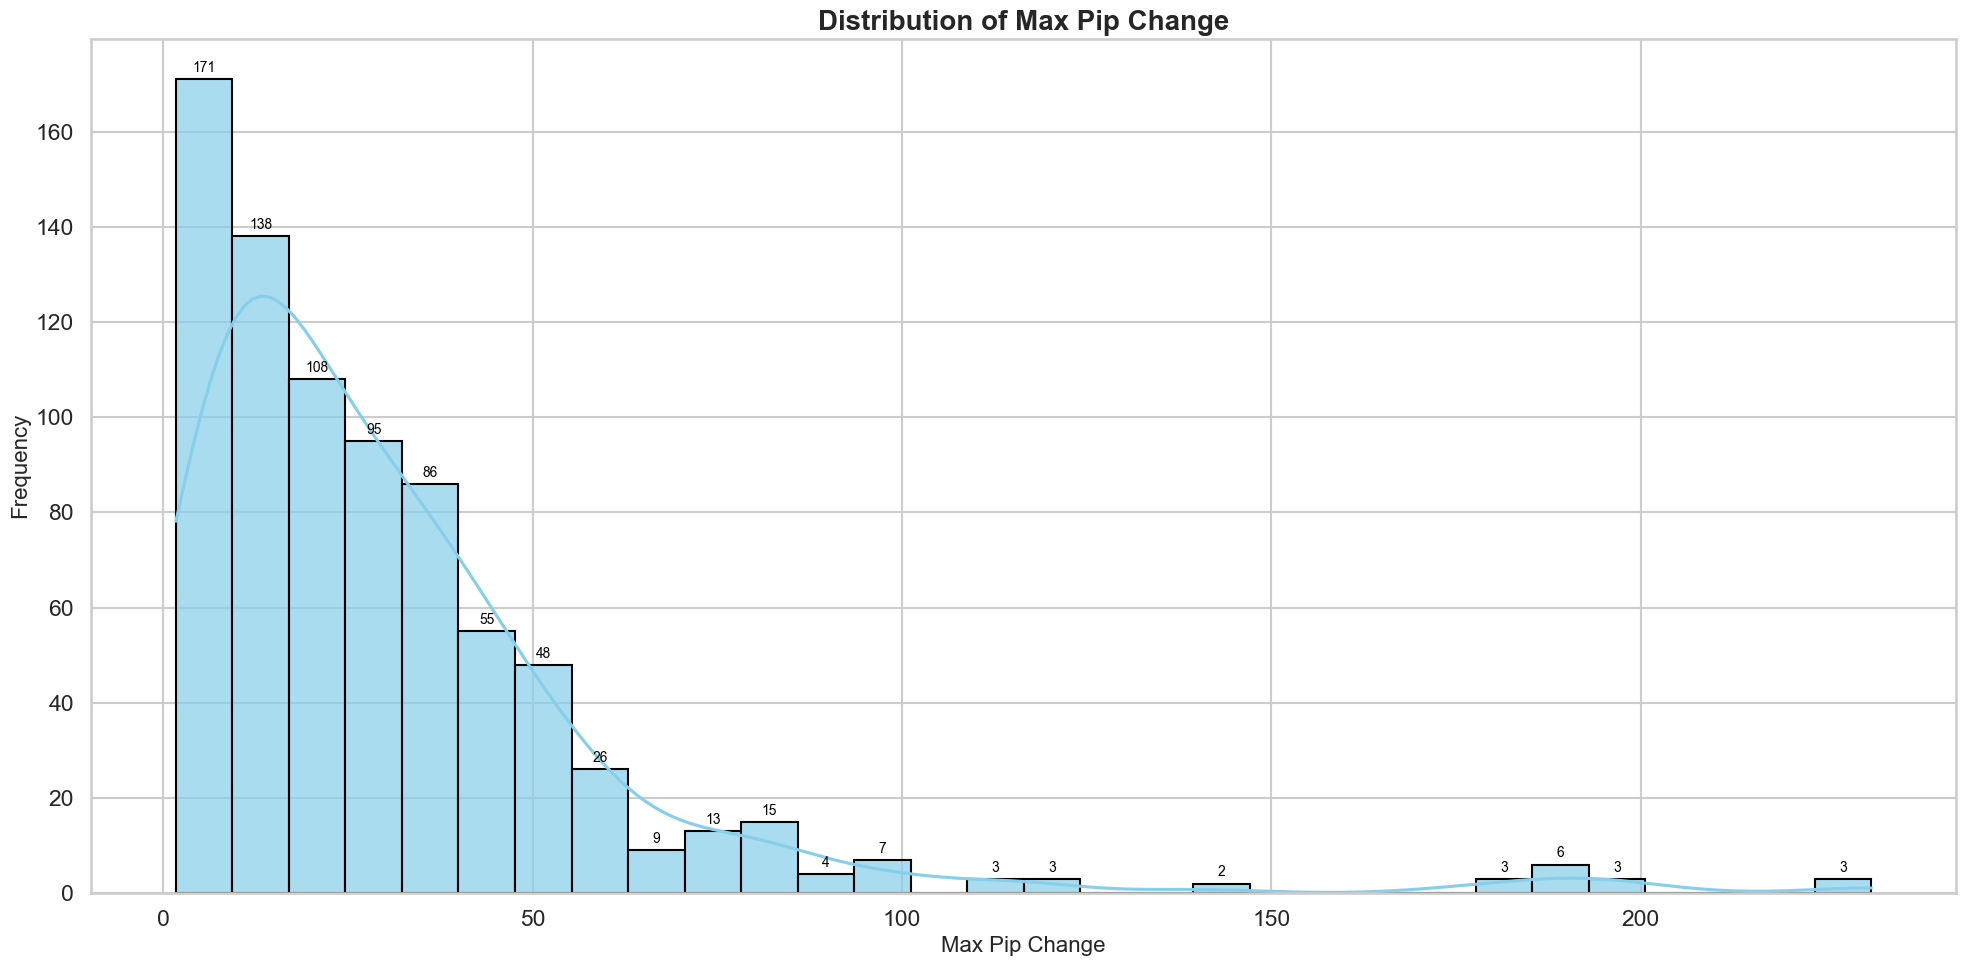

In [83]:
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(20, 10))
hist = sns.histplot(resulted_df['max-pip-change'], bins=30, kde=True, color="skyblue", edgecolor="black", alpha=0.7)
for patch in hist.patches:
    x = patch.get_x() + patch.get_width() / 2
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a count
        hist.annotate(f'{int(height)}', xy=(x, height), xytext=(0, 8), 
                      textcoords='offset points', ha='center', va='center', fontsize=10, color="black")
plt.title("Distribution of Max Pip Change", fontsize=20, fontweight="bold")
plt.xlabel("Max Pip Change", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.tight_layout()
plt.show()


In [84]:
sns.set_theme(style="whitegrid", context="talk")

# Create a box plot
plt.figure(figsize=(14, 8))
sns.boxplot(
    x='trade_type', 
    y='max-pip-change', 
    data=resulted_df, 
    palette="muted",  # Choose a color palette
    linewidth=2,      # Thicker borders for the boxes
    width=0.6,         # Adjust box width
    legend=False
)

# Add labels and title
plt.title("Distribution of Max Pip Change by Trade Type", fontsize=20, fontweight="bold")
plt.xlabel("Trade Type", fontsize=16)
plt.ylabel("Max Pip Change", fontsize=16)

# Customize gridlines and ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show();


TypeError: unhashable type: 'numpy.ndarray'

<Figure size 1400x800 with 0 Axes>

As we can see that most of the values are under 75%. The spikes news are very few. 
So now we will say if any news that is making 80 pips or greater will monster news, 40 pips or greater will be a high impact news and 20 pips or greater will be medium impact news. Anything below 20 pips will be low impact news.

### Monster Logic Earlier

In [ ]:
# def news_category_definition(row):
#     if row['max-pip-change'] >= 60:
#         return 'Monster'
#     elif row['max-pip-change'] >= 20 :
#         return 'Major'
#     else:
#         return 'Minor'
    
# resulted_df['news_category'] = resulted_df.apply(news_category_definition, axis=1)

In [ ]:
# resulted_df['news_category'].value_counts()

news_category
Major      360
Minor      354
Monster     84
Name: count, dtype: int64

In [ ]:
# Give unique names of all news that are monster
# resulted_df[resulted_df['news_category'] == 'Monster']['event'].unique()

array(['CPI y/y', 'CPI m/m', 'Core CPI m/m', 'Unemployment Rate',
       'Average Hourly Earnings m/m', 'Non-Farm Employment Change',
       'PPI m/m', 'Empire State Manufacturing Index',
       'Federal Funds Rate', 'Core PPI m/m', 'Flash Services PMI',
       'ISM Services PMI', 'JOLTS Job Openings', 'Advance GDP q/q',
       'CB Consumer Confidence', 'Flash Manufacturing PMI',
       'Retail Sales m/m', 'Core Retail Sales m/m'], dtype=object)

We can see that there are still some of the outliers. Like Unemployment Rate, which is not that much sensistive, but it comes in combination with other news to make that mosnter. 

In [ ]:
# resulted_df[resulted_df['event'] == 'Unemployment Rate']['max-pip-change'].describe()

count     48.000000
mean      40.268750
std       33.173112
min        7.600000
25%       17.200000
50%       29.750000
75%       49.350000
max      177.700000
Name: max-pip-change, dtype: float64

As you can see it has min value of 7.6 and max of 177. So let's dig into this problem

In [ ]:
unemployment_data = resulted_df[resulted_df['event'] == 'Unemployment Rate']
# unemployment_data['other_events'].unique()

array(['Average Hourly Earnings m/m, Non-Farm Employment Change'],
      dtype=object)

So it always come with Average Hourly Earnings m/m, Non-Farm Employment Change, so we will consider it as a monster news

In [ ]:
# Let's check the average value of it.

np.float64(40.268750000000004)

### Now we will group on basis of news type to classify them as monster, major and minor

In [ ]:
# Here is the first 5 minute max change in pips
resulted_df['max-pip-change'].describe()

count    798.000000
mean      31.314286
std       32.216823
min        1.700000
25%       10.400000
50%       22.800000
75%       39.975000
max      231.200000
Name: max-pip-change, dtype: float64

In [146]:
average_event_change = pd.DataFrame(resulted_df.groupby(['event'])['max-pip-change'].mean().sort_values(ascending=False))
average_event_change.rename(columns={'max-pip-change': 'average_change'}, inplace=True)

<Axes: title={'center': 'Average Change in Pips by Event'}, xlabel='Event', ylabel='Average Change'>

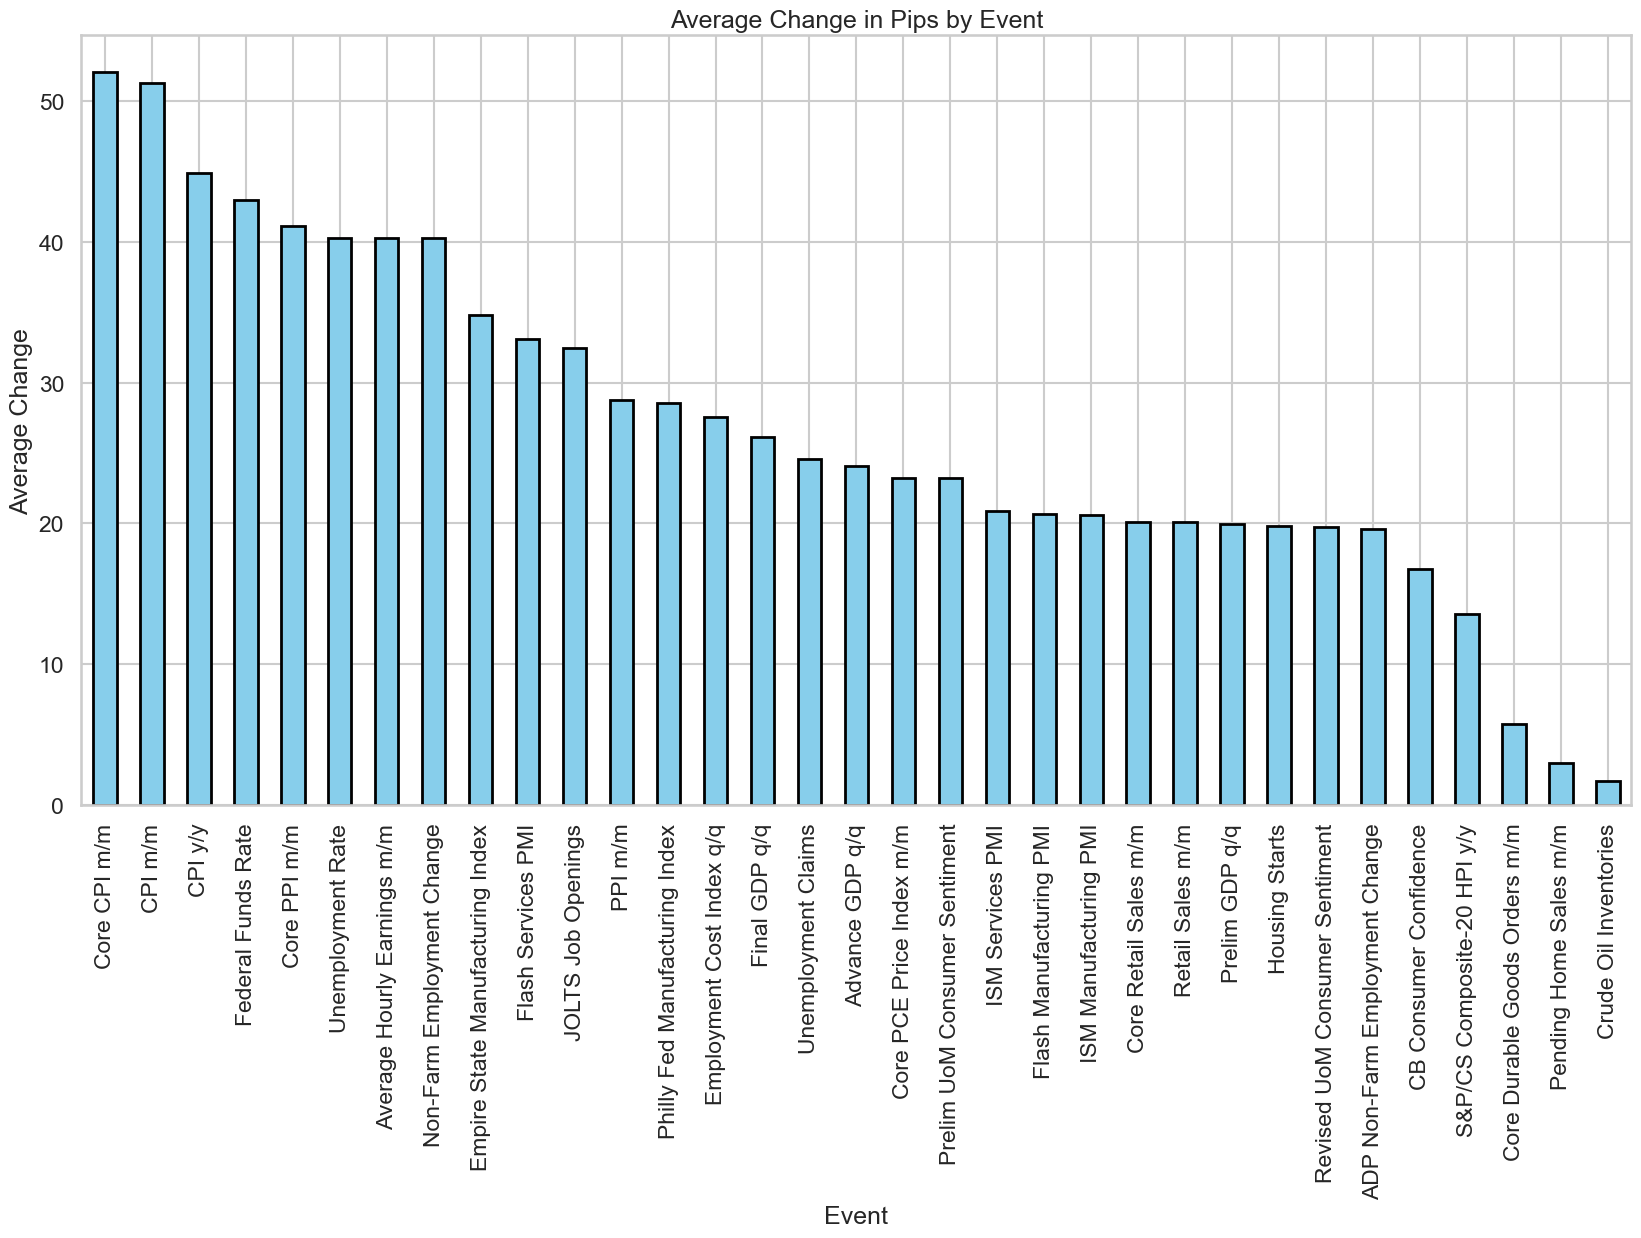

In [147]:
average_event_change['average_change'].plot(kind='bar', figsize=(20, 10), color='skyblue', edgecolor='black', linewidth=2, xlabel='Event', ylabel='Average Change', title='Average Change in Pips by Event')    

In [148]:
average_event_change['news_type'] = np.where(average_event_change['average_change'] >= 35, 'Monster', np.where(average_event_change['average_change'] >= 25, 'Major', 'Minor'))
average_event_change['max_change'] = resulted_df.groupby(['event'])['max-pip-change'].max()
average_event_change['min_change'] = resulted_df.groupby(['event'])['max-pip-change'].min()

In [149]:
average_event_change.head()

,average_change,news_type,max_change,min_change
event,,,,
Core CPI m/m,52.036585,Monster,231.2,3.0
CPI m/m,51.276190,Monster,231.2,3.0
CPI y/y,44.875000,Monster,231.2,1.9
Federal Funds Rate,42.927273,Monster,99.1,6.8
Core PPI m/m,41.084615,Monster,93.0,17.6


In [150]:
average_event_change['news_type'].value_counts()

news_type
Minor      18
Monster     8
Major       7
Name: count, dtype: int64

In [156]:
import matplotlib.pyplot as plt
import numpy as np

def plot_event_comparison(dataset, news_type):
    dataset.reset_index(inplace=True)
    # Assuming 'dataset' contains 'event', 'average_change', 'max_change', 'min_change' columns.
    events = dataset['event']  # or the index if you have events as the index
    average_change = dataset['average_change']
    max_change = dataset['max_change']
    min_change = dataset['min_change']
    
    # Set up the positions of the bars
    bar_width = 0.25
    r1 = np.arange(len(events))  # Position for average bars
    r2 = [x + bar_width for x in r1]  # Position for max bars
    r3 = [x + bar_width for x in r2]  # Position for min bars
    
    # Plot bars for Average, Max, and Min Change
    plt.figure(figsize=(20, 10))
    
    # Create the bars
    avg_bars = plt.bar(r1, average_change, color='skyblue', width=bar_width, edgecolor='black', label='Average Change')
    max_bars = plt.bar(r2, max_change, color='red', width=bar_width, edgecolor='black', label='Max Change')
    min_bars = plt.bar(r3, min_change, color='green', width=bar_width, edgecolor='black', label='Min Change')
    
    # Annotate the bars with their values
    for i in range(len(events)):
        # Add the Average value on top of the average bars
        plt.text(r1[i], average_change[i] + 0.1, f'{average_change[i]:.2f}', ha='center', va='bottom', fontsize=12)
        
        # Add the Max value on top of the max bars
        plt.text(r2[i], max_change[i] + 0.1, f'{max_change[i]:.2f}', ha='center', va='bottom', fontsize=12)
        
        # Add the Min value on top of the min bars
        plt.text(r3[i], min_change[i] + 0.1, f'{min_change[i]:.2f}', ha='center', va='bottom', fontsize=12)

    # Customize plot
    plt.xlabel('Event', fontsize=16)
    plt.ylabel('Change in Pips', fontsize=16)
    plt.title(f'Average, Max, and Min Change in Pips by {news_type} Event', fontsize=20)
    plt.xticks([r + bar_width for r in range(len(events))], events, rotation=90, fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'average_event_change' is a dataframe with columns 'event', 'average_change', 'max_change', 'min_change'
# plot_event_comparison(average_event_change, 'News')


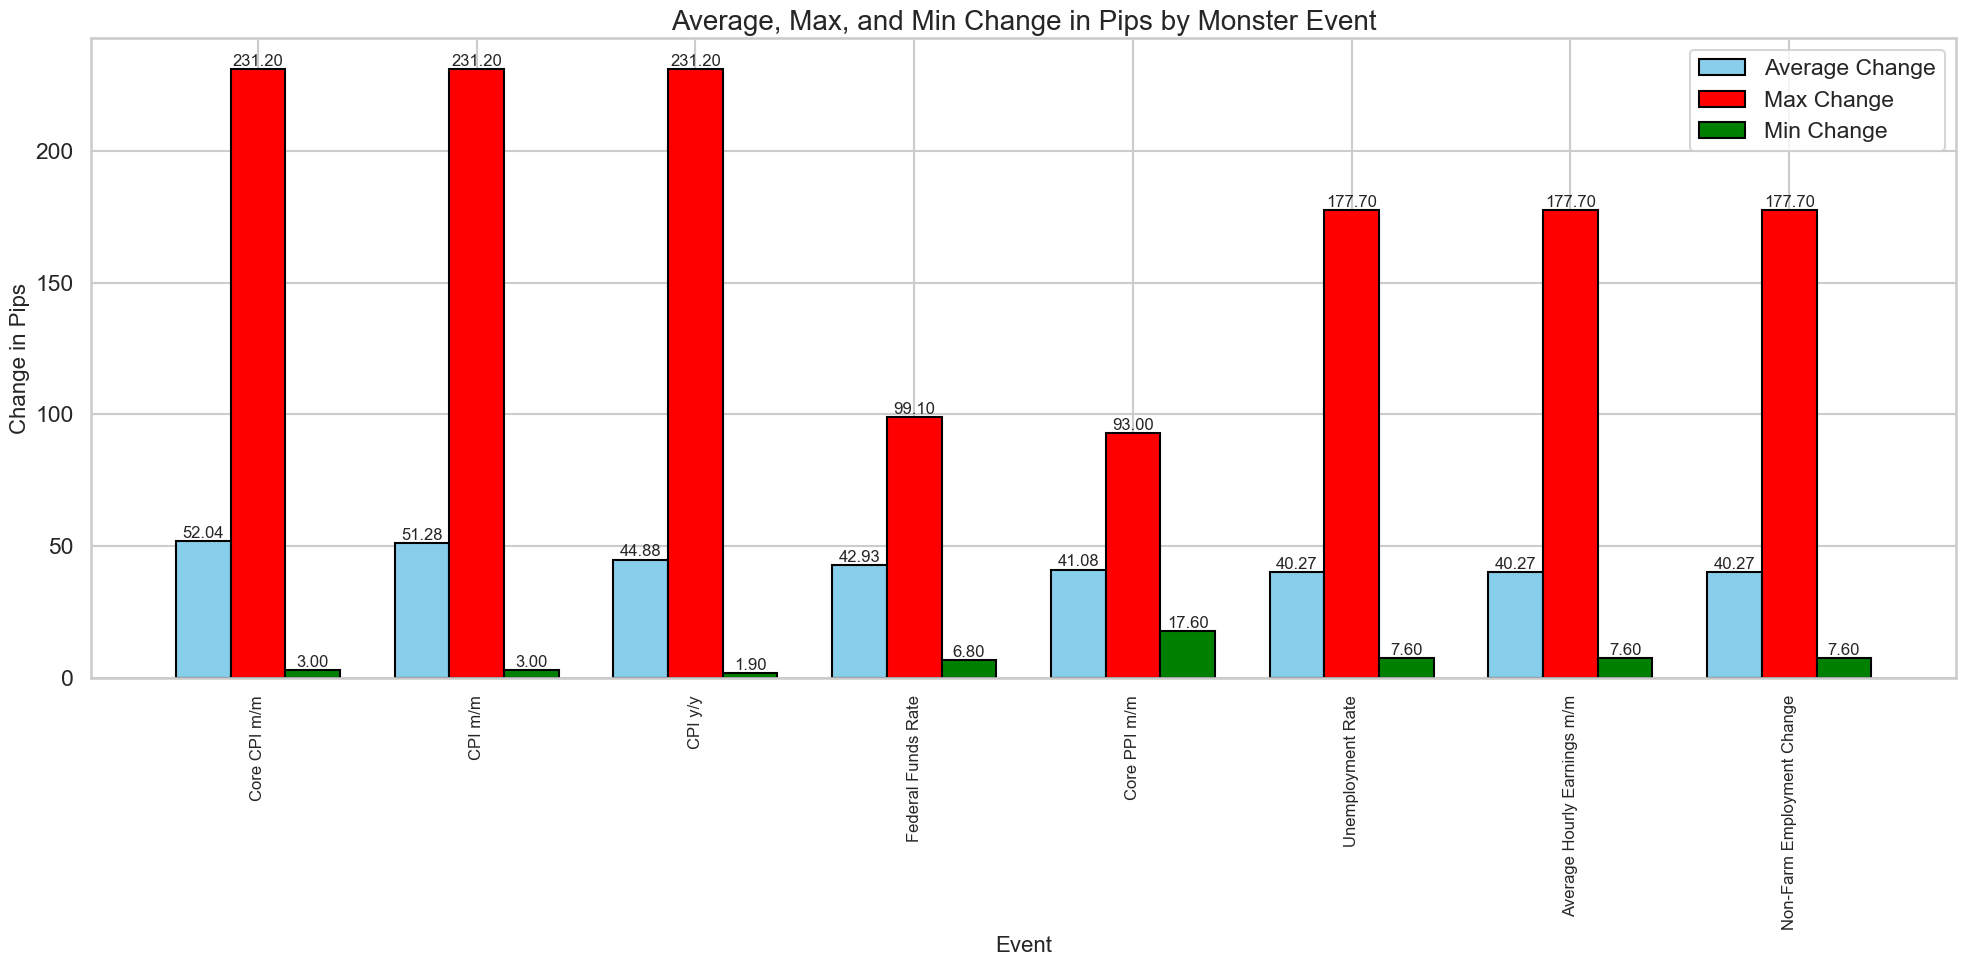

In [157]:
plot_event_comparison(average_event_change[average_event_change['news_type'] == 'Monster'], 'Monster')

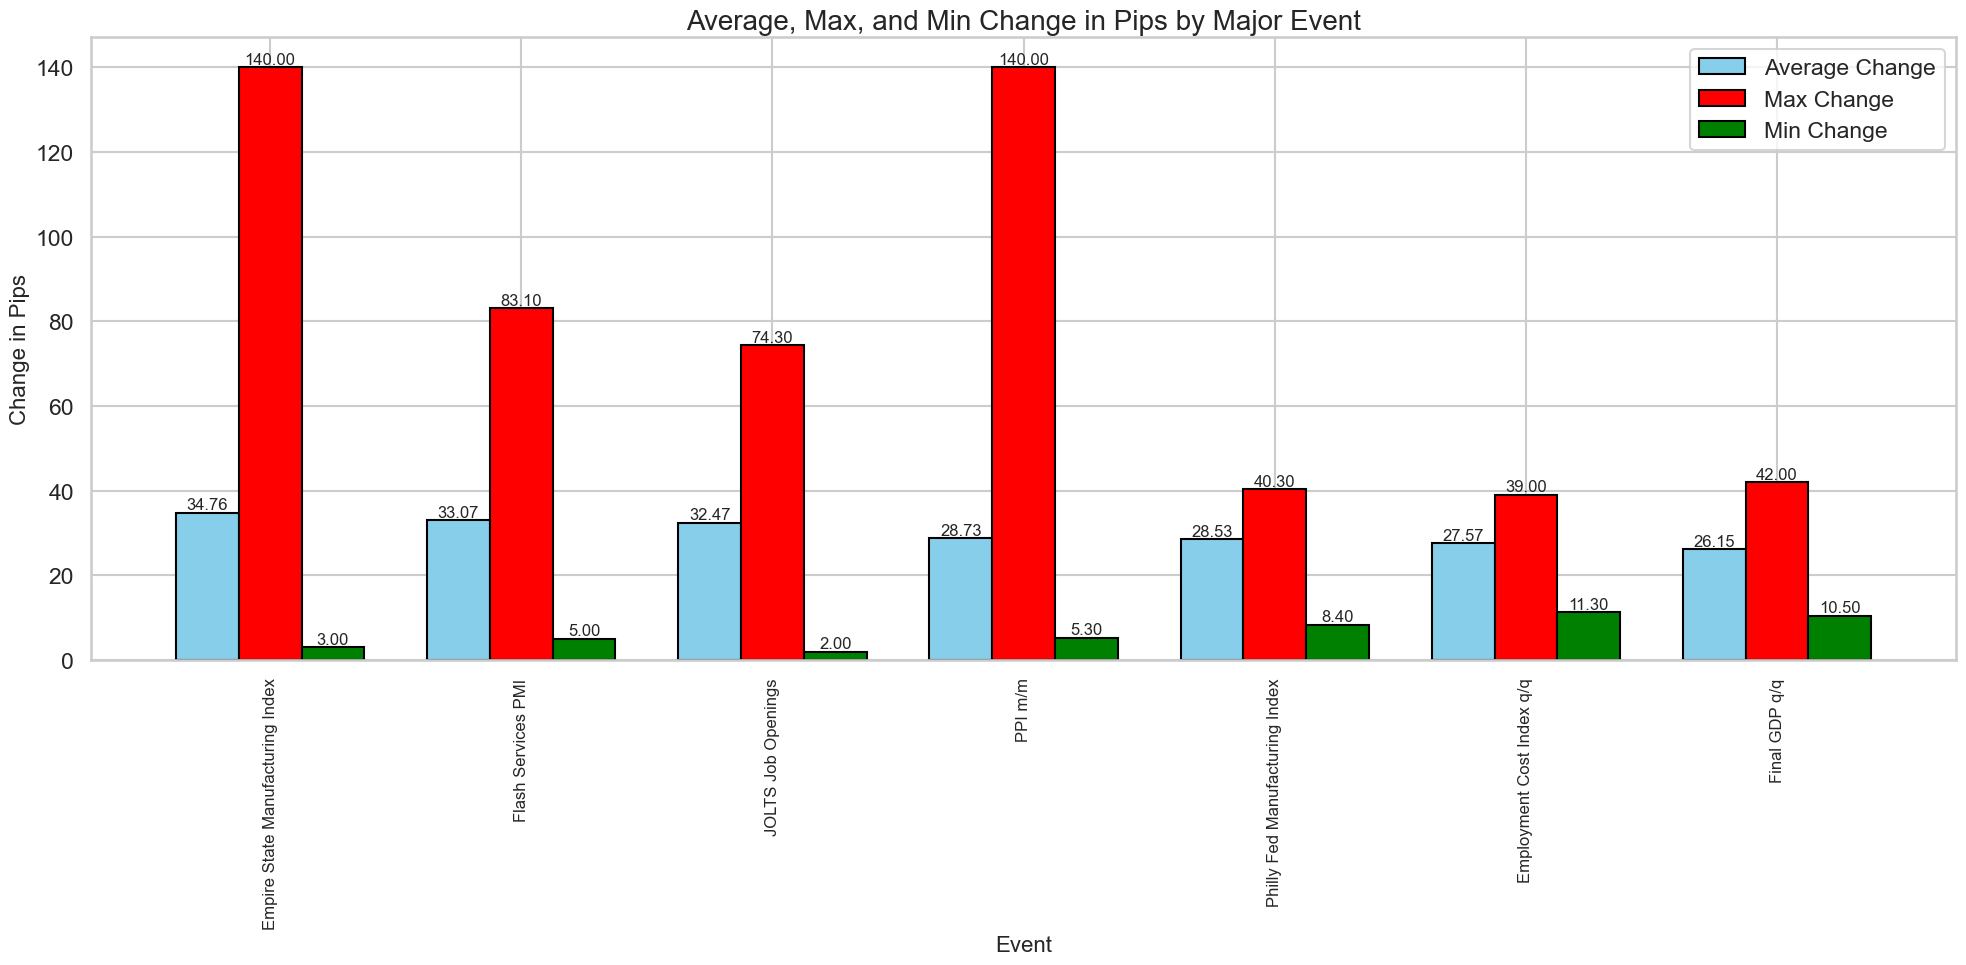

In [158]:
plot_event_comparison(average_event_change[average_event_change['news_type'] == 'Major'], 'Major')

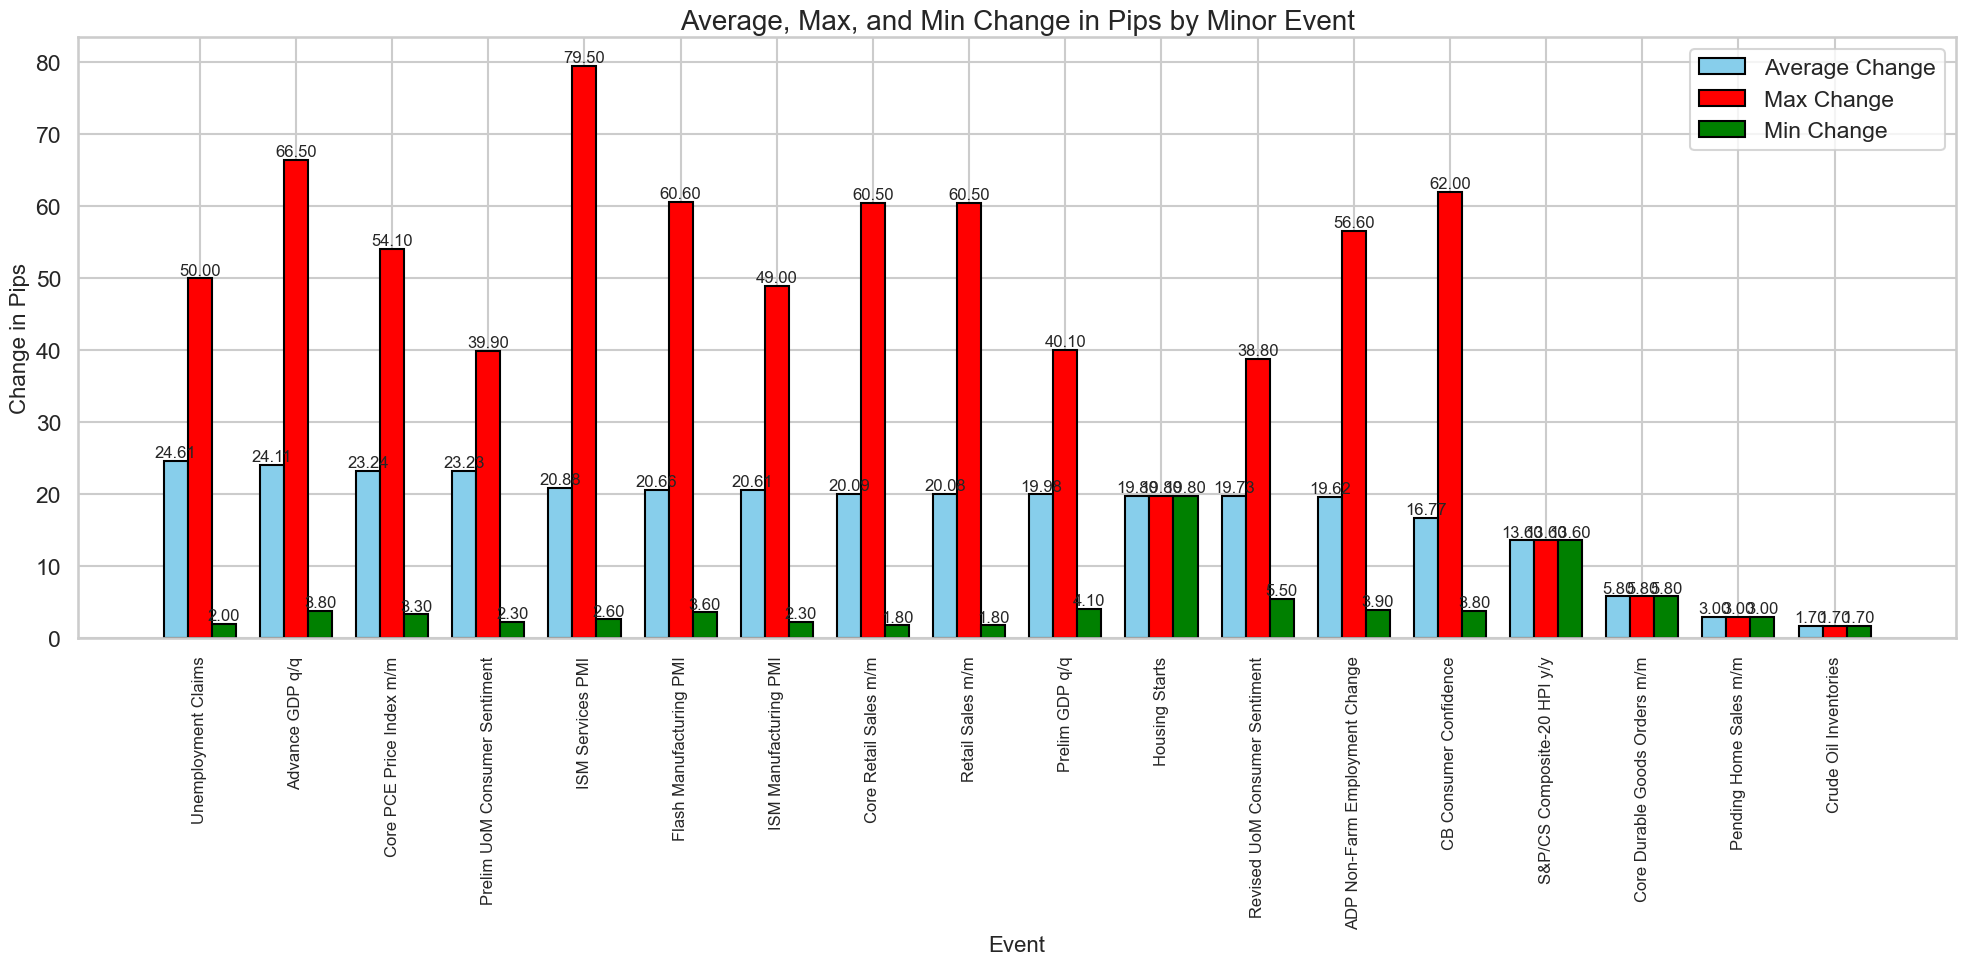

In [159]:
plot_event_comparison(average_event_change[average_event_change['news_type'] == 'Minor'], 'Minor')

In [160]:
# Get the index values
average_event_change[average_event_change['news_type'] == 'Monster'].index

Index(['Core CPI m/m', 'CPI m/m', 'CPI y/y', 'Federal Funds Rate',
       'Core PPI m/m', 'Unemployment Rate', 'Average Hourly Earnings m/m',
       'Non-Farm Employment Change'],
      dtype='object', name='event')

In [161]:
average_event_change[average_event_change['news_type'] == 'Major'].index

Index(['Empire State Manufacturing Index', 'Flash Services PMI',
       'JOLTS Job Openings', 'PPI m/m', 'Philly Fed Manufacturing Index',
       'Employment Cost Index q/q', 'Final GDP q/q'],
      dtype='object', name='event')

In [162]:
average_event_change[average_event_change['news_type'] == 'Major'].index

Index(['Empire State Manufacturing Index', 'Flash Services PMI',
       'JOLTS Job Openings', 'PPI m/m', 'Philly Fed Manufacturing Index',
       'Employment Cost Index q/q', 'Final GDP q/q'],
      dtype='object', name='event')

So in Summary, we have the following categories of news events:<br>
- **Monster**: ['Core CPI m/m', 'CPI m/m', 'CPI y/y', 'Federal Funds Rate',
       'Core PPI m/m', 'Unemployment Rate', 'Average Hourly Earnings m/m',
       'Non-Farm Employment Change']<br><br>
- **Major**: ['Empire State Manufacturing Index', 'Flash Services PMI',
       'JOLTS Job Openings', 'PPI m/m', 'Philly Fed Manufacturing Index',
       'Employment Cost Index q/q', 'Final GDP q/q']<br><br>
- **Minor**: ['Empire State Manufacturing Index', 'Flash Services PMI',
       'JOLTS Job Openings', 'PPI m/m', 'Philly Fed Manufacturing Index',
       'Employment Cost Index q/q', 'Final GDP q/q']

Future Work
- Find out which event is placed in wrong category due to other event happening at the same time.
- Find out whether the same category news is in the same category for other pairs
- Apply machine learning technique to predict the movement of future events